In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/danmuir/Projects/tbfm_multisession/data"
sys.path.append(DATA_DIR)
# imported from JNE project
from tbfm import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"]
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Se0.6828410029411316ssion3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [15]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 73])
Test
torch.Size([2500, 20, 73])


In [16]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

def cfg_big_bases(cfg):
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 100
    cfg.tbfm.module.latent_dim = 3
    cfg.training.epochs = 12001
    cfg.latent_dim = 74
    cfg.ae.use_two_stage = False
    cfg.ae.training.lambda_ae_recon = 0.03
    cfg.tbfm.training.lambda_fro = 60.0

    
cfg.training.epochs = 12001
cfg.latent_dim = 80
cfg.tbfm.module.num_bases = 30
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = False
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 60.0

# cfg_big_bases(cfg)

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)

---- 0 1.422231674194336 0.8514220714569092 0.5598085522651672 0.6200730800628662


In [ ]:
torch.save(embeddings_stim, "es_nf_1.torch")
torch.save(results, "r_nf_1.torch")
torch.save(held_in_session_ids, "hisi_nf_1.torch")

In [6]:
# dim 60
# ---- 0 1.3359395265579224 0.8046253323554993 0.4661109149456024 0.5844032168388367
# ---- 1000 0.4278075695037842 0.6622188687324524 0.5766839385032654 0.6583306789398193
# ---- 2000 0.396166056394577 0.618324875831604 0.6141364574432373 0.6806805729866028
# ---- 3000 0.3778141736984253 0.5973939895629883 0.6342048048973083 0.6913884878158569
# ---- 4000 0.3581080436706543 0.5916580557823181 0.6571977734565735 0.6942155957221985
# ---- 5000 0.34816664457321167 0.5940332412719727 0.6708053946495056 0.6929813623428345
# ---- 6000 0.3581438660621643 0.6191266775131226 0.6658573150634766 0.6801104545593262
# ---- 7000 0.3336026072502136 0.5939902663230896 0.6932620406150818 0.6929448246955872
# ---- 8000 0.3327471911907196 0.6096295714378357 0.6964863538742065 0.6848694086074829
# ---- 9000 0.32028335332870483 0.6060802936553955 0.7111420035362244 0.6866371035575867
# ---- 10000 0.3183406591415405 0.6209917068481445 0.7141416668891907 0.678869366645813
# ---- 11000 0.3536463975906372 0.6276780366897583 0.6893952488899231 0.6756570935249329
# ---- 12000 0.33108434081077576 0.6445168852806091 0.7040227055549622 0.6667747497558594
# Final: 0.6403006315231323 0.6689963936805725

# Dim 60, recon 0.01
# Final: 0.6290900111198425 0.6746326088905334

# Dim 60, recon 0.02
# (0, 0.4652750790119171) (0, 0.5842809677124023)
# (1000, 0.5846171975135803) (1000, 0.6621342897415161)
# (2000, 0.6182869672775269) (2000, 0.6836692094802856)
# (3000, 0.6335306763648987) (3000, 0.6886982321739197)
# (4000, 0.6580140590667725) (4000, 0.6863154768943787)
# (5000, 0.6735500693321228) (5000, 0.6886609196662903)
# (6000, 0.6912528276443481) (6000, 0.6884714365005493)
# (7000, 0.6946881413459778) (7000, 0.6783629655838013)
# (8000, 0.7047398090362549) (8000, 0.6851468086242676)
# (9000, 0.705632746219635) (9000, 0.6886439919471741)
# (10000, 0.7090436816215515) (10000, 0.6628554463386536)
# (11000, 0.7272168397903442) (11000, 0.6862529516220093)
# (12000, 0.7215263247489929) (12000, 0.6816081404685974)
# Final: 0.6828410029411316{'MonkeyG_20150917_Session1_M1': 0.1586693972349167, 'MonkeyG_20150925_Session2_S1': 0.6995167136192322, 'MonkeyJ_20160630_Session3_S1': 0.626221239566803}
0.6995167136192322

# Dim 60, recon 0.005
# Final: 0.6192483901977539 0.6799713373184204

# Latent dim 80 / num bases 30 / filtering
# {'MonkeyG_20150918_Session1_M1': 0.19599013030529022, 'MonkeyG_20150925_Session2_S1': 0.6947001814842224}
# 0.6947001814842224

# Same; 10ms only
# {'MonkeyG_20150917_Session1_M1': 0.1586693972349167, 'MonkeyG_20150925_Session2_S1': 0.6995167136192322, 'MonkeyJ_20160630_Session3_S1': 0.626221239566803}
# 0.6995167136192322

print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])


{'MonkeyG_20150917_Session1_M1': 0.1586693972349167, 'MonkeyG_20150925_Session2_S1': 0.6995167136192322, 'MonkeyJ_20160630_Session3_S1': 0.626221239566803}
0.6995167136192322


In [7]:
for idx, tr2 in enumerate(results["test_r2s"]):
    tra_r2 = results["train_r2s"][idx]
    print(tra_r2, tr2)
print(results["final_test_r2"])

(0, -0.18680456777413687) (0, 0.051349930465221405)
(1000, 0.39018693566322327) (1000, 0.4732474088668823)
(2000, 0.4237717141707738) (2000, 0.4944821298122406)
(3000, 0.4470570683479309) (3000, 0.49911415576934814)
(4000, 0.4548386335372925) (4000, 0.48903998732566833)
(5000, 0.48470794161160785) (5000, 0.5066899061203003)
(6000, 0.5115012725194296) (6000, 0.5088120698928833)
(7000, 0.5154084066549937) (7000, 0.5064784288406372)
(8000, 0.4988556504249573) (8000, 0.507839024066925)
(9000, 0.4905068874359131) (9000, 0.4887046217918396)
(10000, 0.47294536232948303) (10000, 0.48859167098999023)
(11000, 0.5269340574741364) (11000, 0.5114635229110718)
(12000, 0.5109817385673523) (12000, 0.5102698802947998)
0.49480247497558594


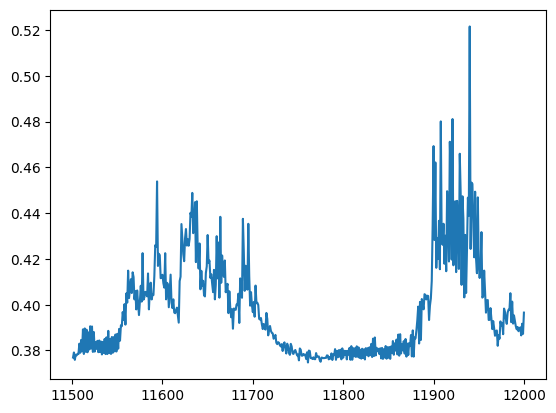

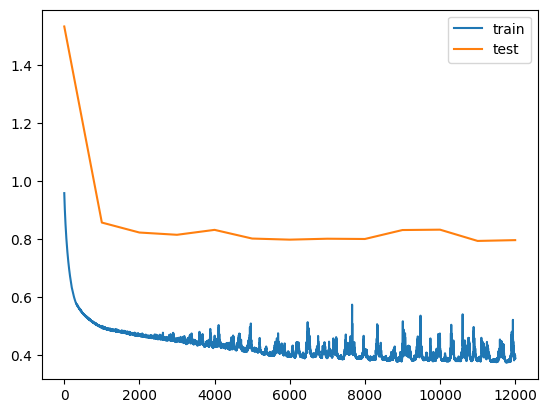

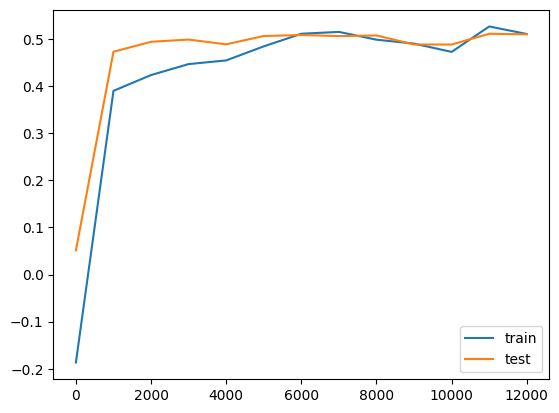

In [8]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [19]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([-0.0614,  0.0382,  0.0541, -0.0395, -0.1412,  0.0947, -0.0753,  0.0451,
         0.0889, -0.0264, -0.0923,  0.0926,  0.0201,  0.0646, -0.2211],
       device='cuda:0')
tensor([-0.0186, -0.1713, -0.0534, -0.1216, -0.0148,  0.0678, -0.0646, -0.0792,
         0.1374, -0.1338,  0.0144, -0.0022, -0.0586, -0.0244,  0.0698],
       device='cuda:0')


tensor([-0.8595, -0.8486, -0.8606, -0.8634, -0.9131, -0.8919, -0.9204, -0.9454,
        -0.9007, -0.9733], device='cuda:0')
------
------
tensor([ 0.9998, -0.5870, -1.2061, -0.5748, -0.4674,  0.6036,  0.4710,  0.2104,
         0.0178,  0.7037], device='cuda:0') tensor([ 1.6939, -0.4528, -2.1166, -0.4125, -0.3056,  0.7648,  0.6016,  0.1709,
         0.0155,  0.5270], device='cuda:0')
tensor([-0.8257, -0.8447, -0.8386, -0.8946, -0.9135, -0.9141, -0.9199, -0.9029,
        -0.9191, -0.9498], device='cuda:0')


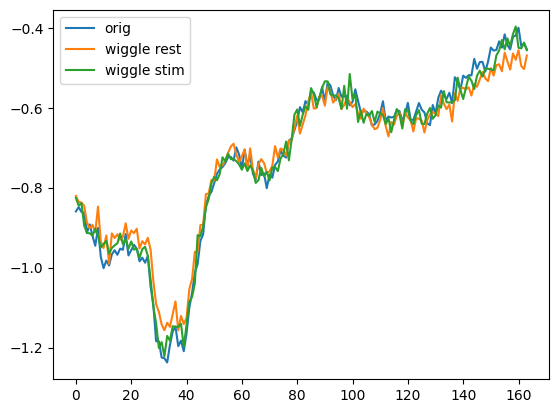

In [9]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]


def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 1.2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


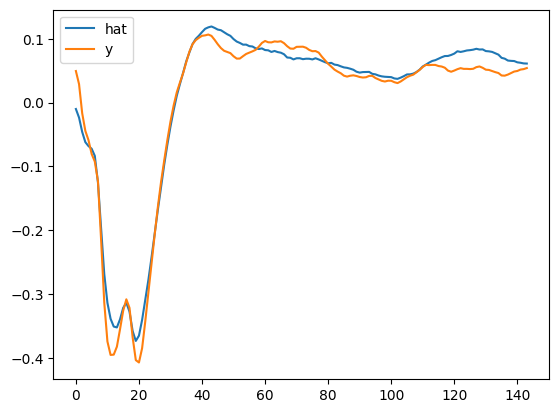

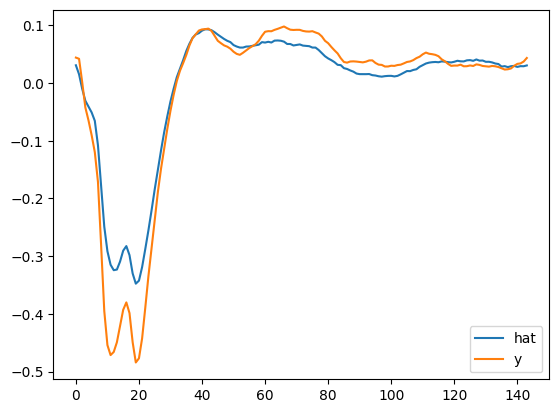

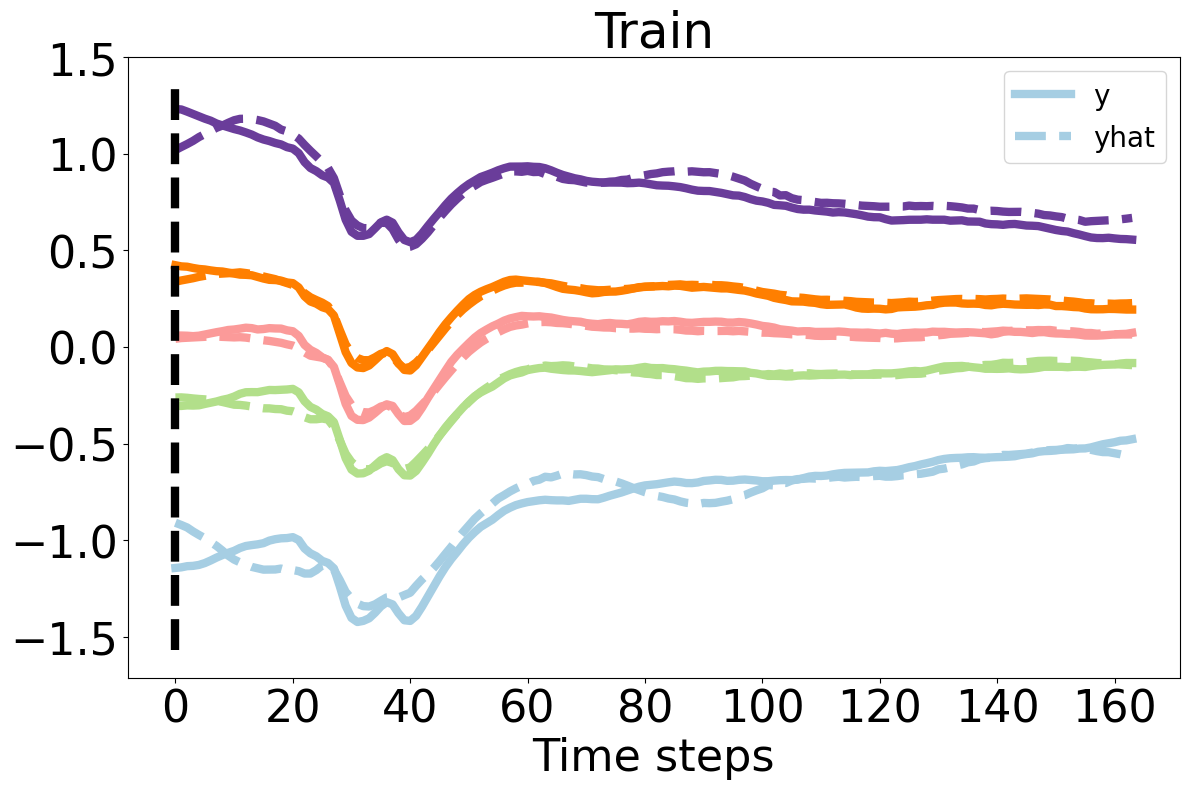

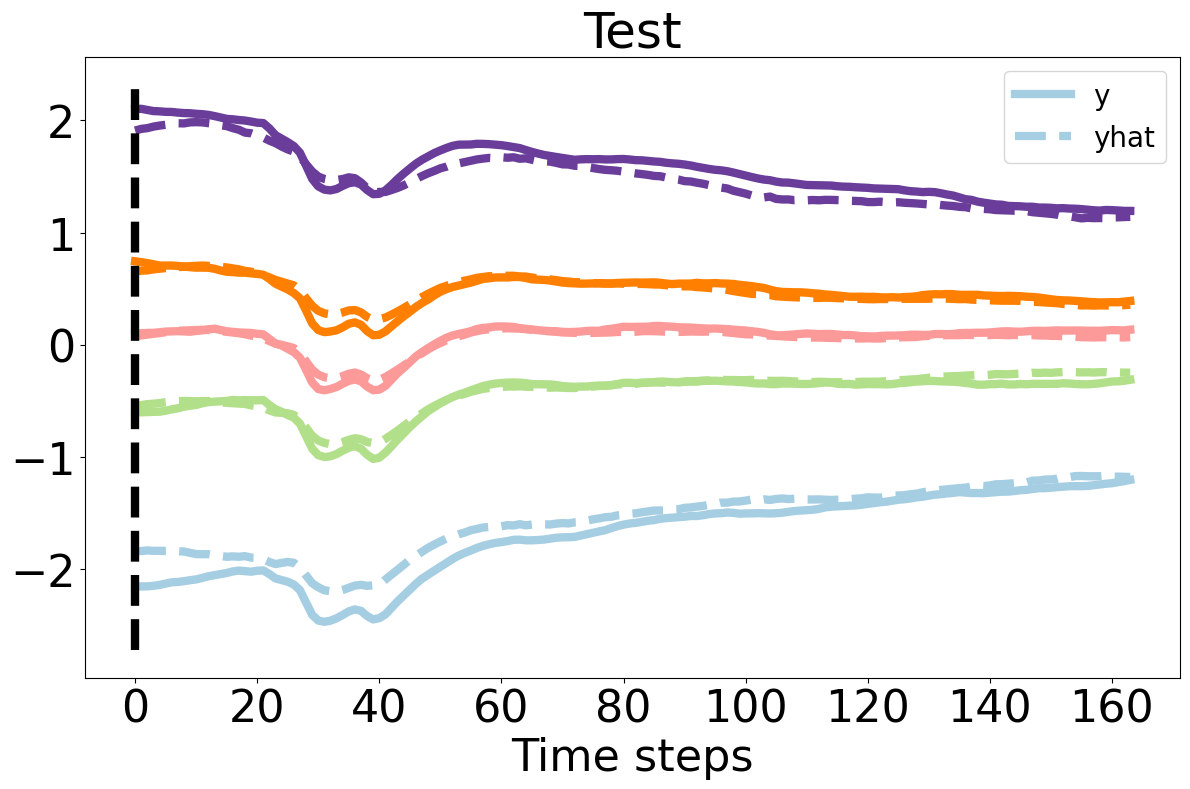

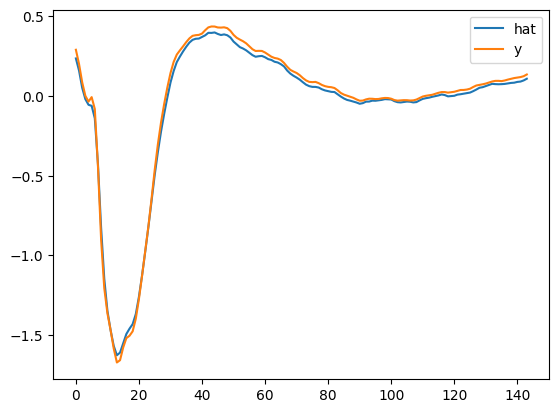

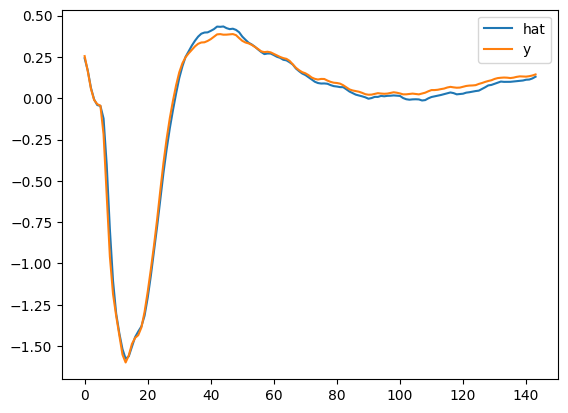

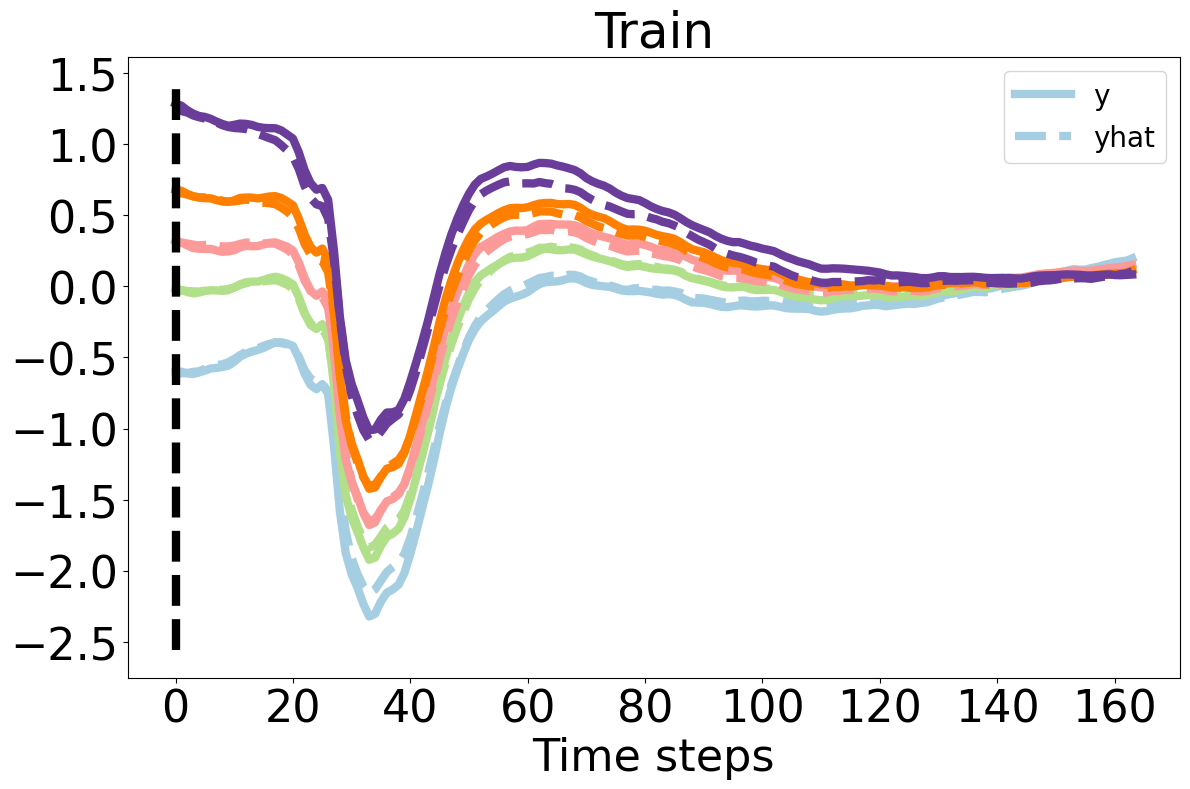

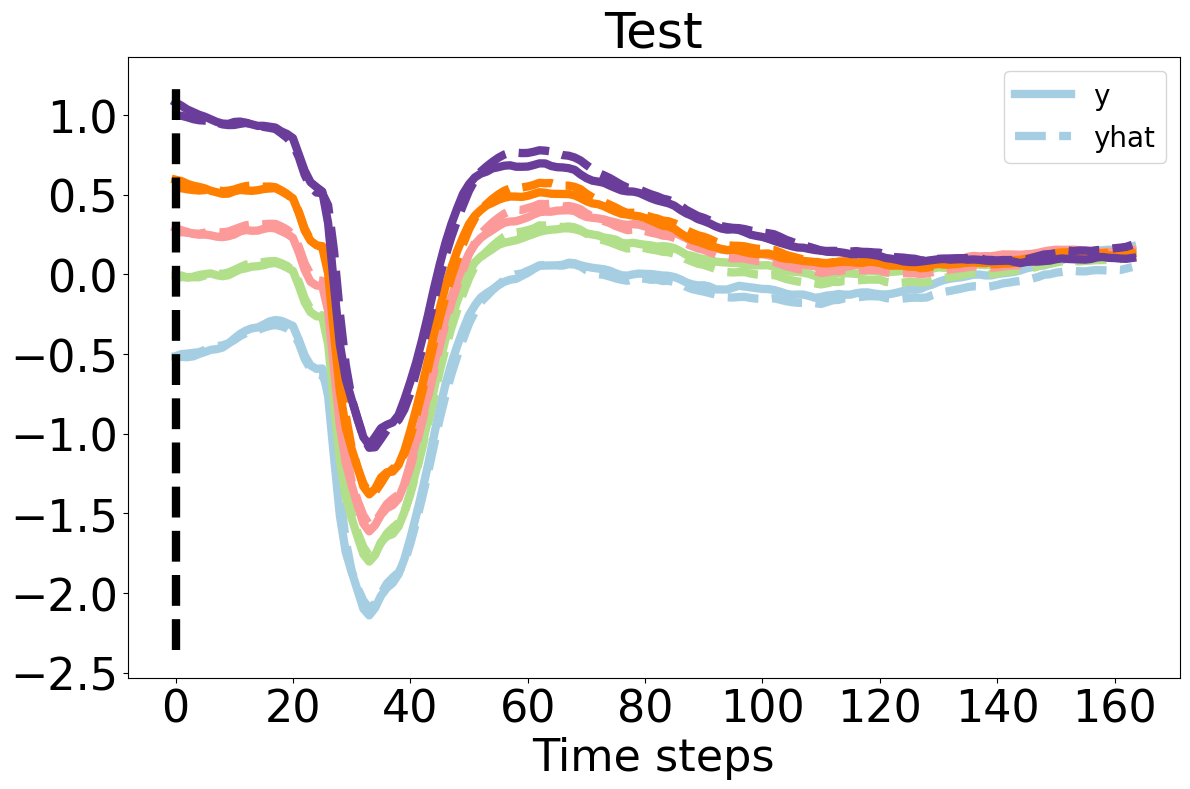

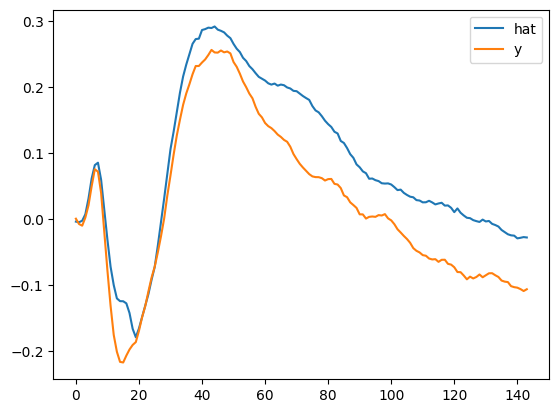

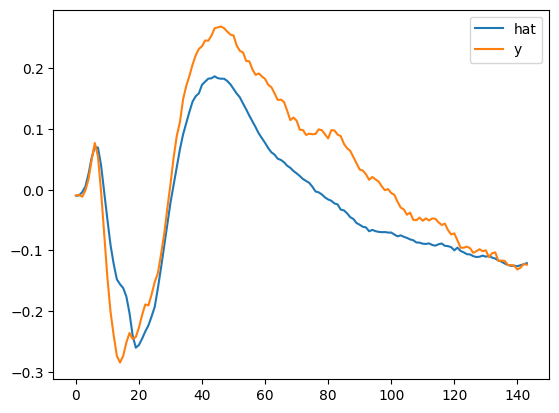

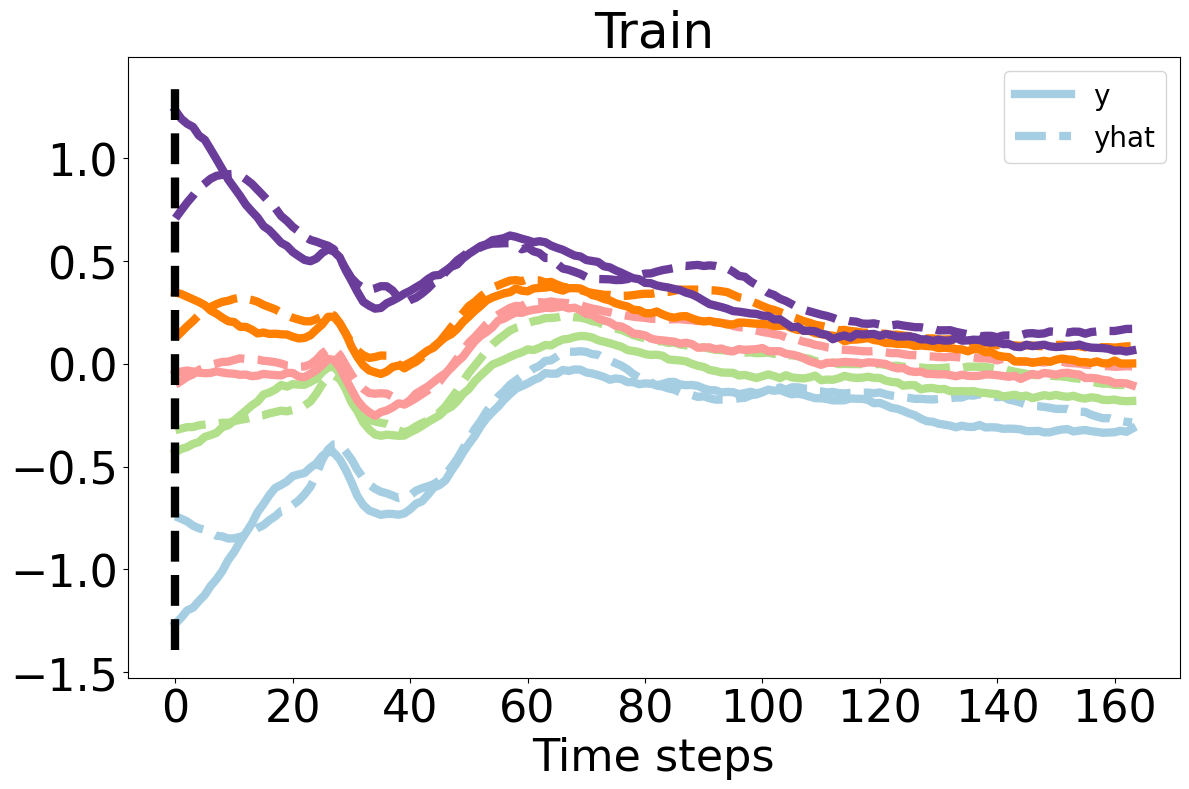

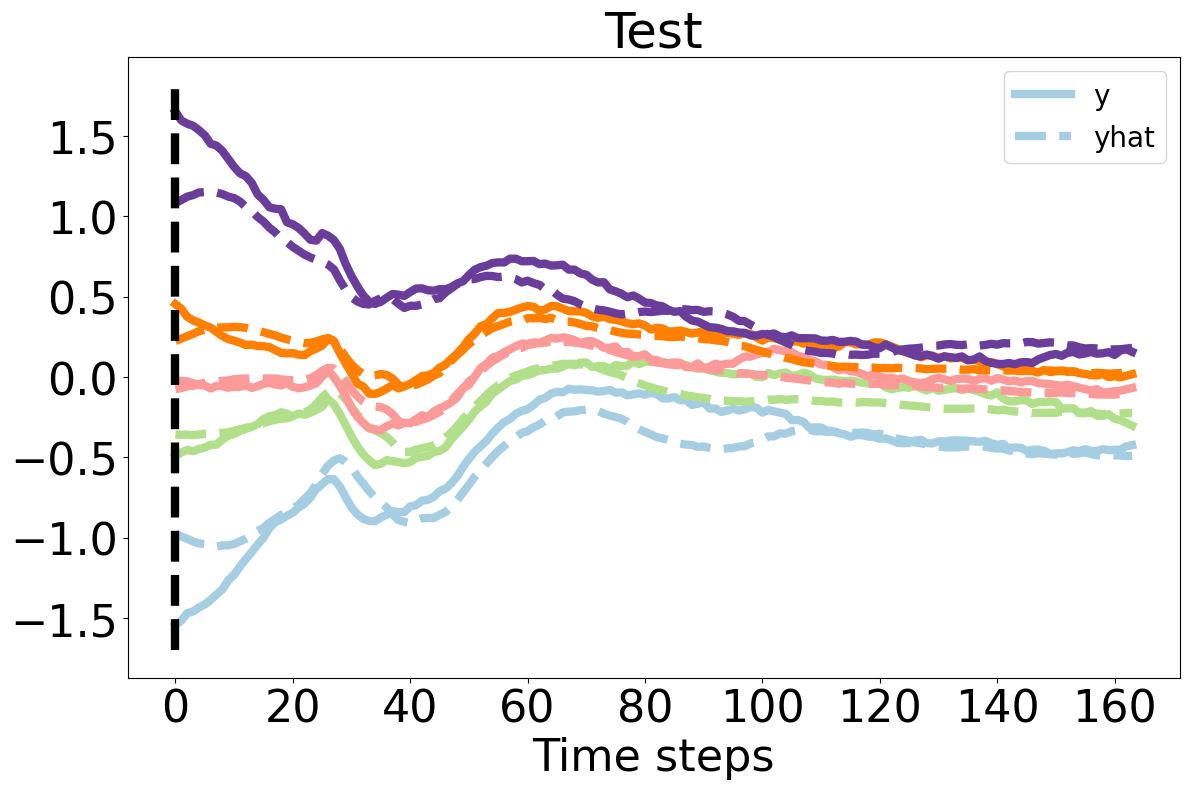

In [11]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)
    plt.show()
    
graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
graph_for_sid('MonkeyJ_20160630_Session3_S1', results, cidx=22)  # 10ms
graph_for_sid('MonkeyG_20150917_Session1_M1', results, cidx=30)  # 10ms

# graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150915_Session3_S1', results)

In [ ]:
# Try:
# cfg.tbfm.module.latent_dim = (16, 32, 64)
# cfg.tbfm.module.embed_dim_stim = (3, 7, 15, 20)

for latent_dim in (16, 32, 64):
    for embed_dim_stim in (3, 7, 15, 20):
        print("---------------", latent_dim, embed_dim_stim)

        # cfg.tbfm.training.lambda_fro = regweight
        # cfg.tbfm.module.num_bases = num_bases
        # cfg.training.grad_clip = grad_clip
        # cfg.latent_dim = latent_dim
        # cfg.tbfm.training.optim.lr_head = lr_head
        # cfg.tbfm.training.lambda_ortho = lambda_ortho
        cfg.tbfm.module.latent_dim = latent_dim
        cfg.tbfm.module.embed_dim_stim = embed_dim_stim
        # cfg.tbfm.module.use_film_bases = True
        # cfg.ae.training.coadapt = True
        cfg.training.epochs = 15001

        ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
        model_optims = multisession.get_optims(cfg, ms)
        
        embeddings_stim, results = multisession.train_from_cfg(
            cfg,
            ms,
            data_train,
            model_optims,Carmen
            embeddings_rest,
            data_test=data_test,
            test_interval=5000,
            epochs=cfg.training.epochs,
            )
        torch.save(results, f"res_{latent_dim}_{embed_dim_stim}.torch")

        del model_optims, ms

--------------- 16 3
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1575546264648438 0.9233913421630859 0.0376604589788864 0.062086887657642365
---- 5000 0.5894997715950012 0.5439465641975403 0.4358087678750356 0.44218406081199646
---- 10000 0.5419514775276184 0.5320742130279541 0.48556982477506 0.4532109498977661


In [7]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)


# (0.4636920392513275, './res_2.0_15_0.1.torch')
# (0.463911235332489, './res_7.0_25_0.1.torch')
# (0.4639878273010254, './res_2.0_15_0.01.torch')
# (0.4647655487060547, './res_2.0_20_0.05.torch')Carmen
# (0.4657297134399414, './res_7.0_20_0.01.torch')
# (0.4676693379878998, './res_7.0_25_0.05.torch')
# (0.4676762521266937, './res_7.0_15_0.01.torch')
# (0.46845221519470215, './res_2.0_20_0.1.torch')
# (0.4699900150299072, './res_2.0_25_0.01.torch')
# (0.4754122197628021, './res_2.0_20_0.01.torch')

(0.4600786566734314, './res_64_15.torch')
(0.46490734815597534, './res_32_20.torch')
(0.4654322862625122, './res_64_7.torch')
(0.4656924605369568, './res_64_3.torch')
(0.46584925055503845, './res_16_3.torch')
(0.4660493731498718, './res_32_7.torch')
(0.467379093170166, './res_32_3.torch')
(0.46820545196533203, './res_16_7.torch')
(0.4695136547088623, './res_32_15.torch')
(0.4742690324783325, './res_16_15.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}


In [12]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=5000, lr=1e-4, weight_decay=0, data_test=data_test)
print(results["final_test_r2s"])

0 0.48772335052490234
100 0.4897957742214203
200 0.48833775520324707
300 0.4882700443267822
400 0.4876187741756439
500 0.4883016049861908
600 0.4877614974975586
700 0.4885075092315674
800 0.48906463384628296
900 0.4888041019439697
1000 0.4889765679836273
1100 0.48813408613204956
1200 0.48878902196884155
1300 0.4889551103115082
1400 0.4879341721534729
1500 0.48845916986465454
1600 0.4879935681819916
1700 0.4878040552139282
1800 0.4886717200279236
1900 0.48854583501815796
2000 0.4889155328273773
2100 0.48886704444885254
2200 0.48839110136032104
2300 0.4886503219604492
2400 0.48879560828208923
2500 0.4887659549713135
2600 0.48845410346984863
2700 0.4881424307823181
2800 0.4880937933921814
2900 0.4883902072906494
3000 0.48806774616241455
3100 0.48863673210144043
3200 0.48819440603256226
3300 0.48833829164505005
3400 0.48855113983154297
3500 0.48908644914627075
3600 0.48786696791648865
3700 0.4888080358505249
3800 0.48931822180747986
3900 0.488107293844223
4000 0.4885980486869812
4100 0.488

In [17]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]
        
    print(y_hats.shape, y_hats_test.shape, y.shape, y_test.shape, y_hats_test2.shape, y_hats2.shape)

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)



torch.Size([5000, 164, 60]) torch.Size([4700, 164, 60]) torch.Size([4700, 164, 60]) ----
torch.Size([4656, 164, 60]) torch.Size([2496, 164, 60]) torch.Size([4656, 164, 60]) torch.Size([2496, 164, 60]) torch.Size([2500, 164, 60]) torch.Size([4700, 164, 60])


IndexError: index 4664 is out of bounds for dimension 0 with size 4656